# 1. Importando bibliotecas e imagem

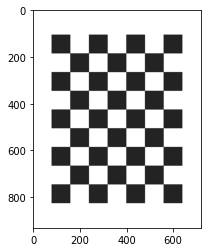

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as st
import cv2
np.random.seed(0)

image = np.array(mpimg.imread('calibration-pattern.png')[:, :, 0])
plt.imshow(image, cmap="gray")

# 2. Definição de métodos úteis

Aqui são definidos 2 métodos obtidos na internet para acelerar a execução do código visto que essas implementações são mais rapidas que as que eu tinha feito.

* ```conv2d(a, f)``` Retorna o resultado da convolução do filtro ```f``` na matriz ```a```.
* ```gaussian_kernel(size, sigma)``` Retorna uma matriz de tamanho ```size x size``` com um filtro gaussiano de $\sigma = $ ```sigma```

In [2]:
# Fast 2d convolution (only using numpy) implementation found in
# https://stackoverflow.com/questions/2448015/2d-convolution-using-python-and-numpy
# by Daniel F.
def conv2d(a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape=s, strides=a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

# Fast resizable gaussian kernel generation using numpy and scipy found in
# https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
# by FuzzyDuck
def gaussian_kernel(size, sigma):
    x = np.linspace(-sigma, sigma, size + 1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d / kern2d.sum()

# 3. Implementação da função do cálculo do Harris

Aqui fica a implementação do algoritmo em questão assim como uma header padronizada para a implementaçao do OpenCV do mesmo algoritmo.

* ```harris_mine(img, k=0.05, sigma=1)``` O método implementado como atividade que calcula a matriz R **sem** a supressão de não máximo com ```k = 0.05``` e ```sigma = 1``` para os filtros gaussianos.

* ```harris_opencv(image)``` Chamada da implementação do algoritmo pela biblioteca OpenCV com ```blackSize = 5```, ```ksize = 3``` e ```k = 0.05```.

* ```get_harris_corners(image, harris_func, ws=50)``` Implementa o algoritmo de supressão de não máximos e encontra a posição dos pixels das bordas.

In [3]:
def harris_mine(img, k=0.05, sigma=1):
    # Defining sobels for derivatives
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Calculating the X and Y derivatives of the image using the sobel kernel
    Ix = conv2d(img, sobel_x)
    Iy = conv2d(img, sobel_y)

    # Calculating Ixx, Ixy and Iyy
    Ixx = Ix * Ix
    Ixy = Ix * Iy
    Iyy = Iy * Iy

    # Applying the window function using a 5x5 gaussian kernel
    gaussian = gaussian_kernel(size=5, sigma=sigma)
    Ixx_gauss = conv2d(Ixx, gaussian)
    Ixy_gauss = conv2d(Ixy, gaussian)
    Iyy_gauss = conv2d(Iyy, gaussian)
    
    # det(M) = G(Ixx) G(Iyy) - G(Ixy)^2
    det = Ixx_gauss * Iyy_gauss - np.power(Ixy_gauss, 2)

    # trace(M) = G(Ixx) + G(Iyy)
    trace = Ixx_gauss + Iyy_gauss

    # R = det(M) - k * trace(M)^2
    R = det - k * np.power(trace, 2)
    return R

def harris_opencv(image):
    return cv2.cornerHarris(image, 5, 3, 0.05)

def get_harris_corners(image, harris_func, ws=50):
    R = harris_func(image)
    
    wd = ws // 2
    harris_positions = []
    for i in range(wd, R.shape[0] - wd):
        for j in range(wd, R.shape[1] - wd):
            window = R[i - wd : i + wd + 1, j - wd : j + wd + 1]
            if R[i, j] > 0 and R[i, j] == np.max(window):
                harris_positions.append((j, i))
                
    return harris_positions

# 4. Teste simples

Um teste visual simples para validar que o algoritmo parece funcionar.

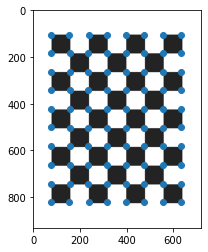

Number of corners: 80


In [4]:
harris_positions = get_harris_corners(image, harris_mine)

xs = [p[0] for p in harris_positions]
ys = [p[1] for p in harris_positions]
plt.imshow(image, cmap="gray")
plt.scatter(xs, ys)
plt.show()

print("Number of corners:", len(harris_positions))

# 5. Teste de robustez

Aqui serão definidos as funções para ao fim gerar os gráficos comparativos entre a implementação do OpenCV e a minha.

## 5.1. Gerando as coordenadas das posições reais

Como os quadrados da imagem escolhida são perfeitamente quadrados, podemos utilizar um simples algoritmo para encontrar todas as posições das bordas reais da imagem. O algoritmo começa do canto superior esquerdo e passa por cada intervalo de 80 pixels (tamanho lateral de cada quadrado) e encontra uma borda naquele local.

In [5]:
square_side = 80 # In pixels
top_left = (78, 104)
square_count = (7, 9)

true_positions = []
for x in range(square_count[0] + 1):
    for y in range(square_count[1] + 1):
        true_positions.append((top_left[0] + square_side * x, top_left[1] + square_side * y))
        
print("Number of corners:", len(true_positions))

Number of corners: 80


## 5.2. Funções geradoras de estatísticas

Aqui será definida a função que a partir da imagem, dos pontos reais e de uma função para calcular a matriz $R$ do algoritmo de Harris gerará as estatísticas alvo (RMS, número de pontos faltando e número de pontos espúrios).

In [6]:
def is_same_point(a, b, threshold=25):
    return np.hypot(b[0] - a[0], b[1] - a[1]) < threshold

def get_performance(image, true_positions, harris_func):
    harris_positions = get_harris_corners(image, harris_func)
    
    correspondences = []
    harris_pts_used = [False] * len(harris_positions)
    true_pts_used = [False] * len(true_positions)
    for i, harris_pt in enumerate(harris_positions):
        for j, true_pt in enumerate(true_positions):
            if is_same_point(harris_pt, true_pt):
                harris_pts_used[i] = True
                true_pts_used[j] = True
                correspondences.append((harris_pt, true_pt))

    missing_points = [pt for pt, used in zip(true_positions, true_pts_used) if not used]
    spurious_points = [pt for pt, used in zip(harris_positions, harris_pts_used) if not used]
    distances = np.array([np.hypot(a[0] - b[0], a[1] - b[1]) for a, b in correspondences])
    return {
        "rms": np.sqrt(np.mean(np.square(distances))),
        "missing": len(missing_points),
        "spurious": len(spurious_points)
    }

## 5.3. Gerando imagens com diferentes níveis de Gaussian noise

Nesse bloco geraremos diferentes imagens com níveis de ruídos diferentes. No total serão 12 imagens com ruído gaussiano indo linearmente de ```std = 0``` até ```std = 1``` (com ```mean``` sendo mantido em 0 para todas elas).

A aparência das imagens também podem ser vistas abaixo.

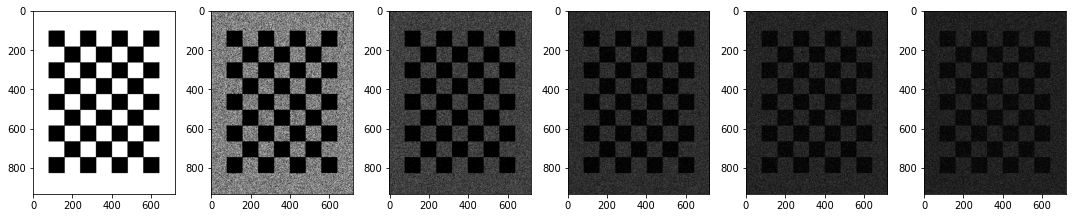

In [7]:
def generate_noisy_image(img, params):
    mean, sigma = params
    gaussian = np.random.normal(mean, sigma, (img.shape[0],img.shape[1])) 
    return np.clip(img + gaussian, 0, 255).astype("uint8")

noise_parameters = [(0, std) for std in np.linspace(0, 1, 12)] # (mean, std)
noisy_images = [generate_noisy_image(image, param) for param in noise_parameters]

fig, axs = plt.subplots(1, len(noisy_images) // 2, figsize=(15, 10))
for ax, img in zip(axs, noisy_images[::2]):
    ax.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()

## 5.4. Gerando estatísticas para cada imagem

No bloco abaixo temos loop principal que pegará cada uma das imagens ruidosas e jogará dentro da função ```generate_noisy_image``` guardando os resultados separadamente de cada variável para a implementação do OpenCV e a minha.

Os resultados serão guardados no dicionário ```perf_data```.

In [ ]:
perf_data = {
    "mean": [],
    "std": [],
    "mine_rms": [],
    "mine_missing": [],
    "mine_spurious": [],
    "opencv_rms": [],
    "opencv_missing": [],
    "opencv_spurious": []
}

for img, params in zip(noisy_images, noise_parameters):
    print("Generating performance for", params, img.dtype)
    mine_perf = get_performance(img, true_positions, harris_mine)
    opencv_perf = get_performance(img, true_positions, harris_opencv)
    
    perf_data["mean"].append(params[0])
    perf_data["std"].append(params[1])
    perf_data["mine_rms"].append(mine_perf["rms"])
    perf_data["mine_missing"].append(mine_perf["missing"])
    perf_data["mine_spurious"].append(mine_perf["spurious"])
    perf_data["opencv_rms"].append(opencv_perf["rms"])
    perf_data["opencv_missing"].append(opencv_perf["missing"])
    perf_data["opencv_spurious"].append(opencv_perf["spurious"])

Generating performance for (0, 0.0) uint8
Generating performance for (0, 0.09090909090909091) uint8
Generating performance for (0, 0.18181818181818182) uint8
Generating performance for (0, 0.2727272727272727) uint8
Generating performance for (0, 0.36363636363636365) uint8
Generating performance for (0, 0.4545454545454546) uint8


## 5.5. Plotando os resultados

Plotando os resultados obtidos conforme o enunciado do quiz. Em vermelho nos gráficos temos os resultados da implementação do OpenCV e em azul temos os resultados da minha implementação.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].plot(perf_data["std"], perf_data["mine_rms"], linewidth=3, color="#3498db", label="Quiz #3")
axs[0].plot(perf_data["std"], perf_data["opencv_rms"], linewidth=3, color="#e74c3c", label="OpenCV")
axs[0].set_xlabel("Noise Standard Deviation")
axs[0].set_ylabel("Points Root Mean Square")
axs[0].legend(loc="best")
axs[0].set_title("RMS Comparision")

axs[1].plot(perf_data["std"], perf_data["mine_missing"], linewidth=3, color="#3498db", label="Quiz #3")
axs[1].plot(perf_data["std"], perf_data["opencv_missing"], linewidth=3, color="#e74c3c", label="OpenCV")
axs[1].set_xlabel("Noise Standard Deviation")
axs[1].set_ylabel("Missing Points")
axs[1].legend(loc="best")
axs[1].set_title("Missing Points Comparision")

axs[2].plot(perf_data["std"], perf_data["mine_spurious"], linewidth=3, color="#3498db", label="Quiz #3")
axs[2].plot(perf_data["std"], perf_data["opencv_spurious"], linewidth=3, color="#e74c3c", label="OpenCV")
axs[2].set_xlabel("Noise Standard Deviation")
axs[2].set_ylabel("Spurious Points")
axs[2].legend(loc="best")
axs[2].set_title("Spurious Points Comparision")

plt.show()

# 6. Conclusão

Como pode ser visto pelos gráficos comparando minha implementação com a implementação da biblioteca OpenCV, os resultados obtidos são muito bons, as vezes superando os resultados obtidos por meio da implementação da biblioteca.

A comparação entre o RMS em específico relata uma pequena vantagem nos resultados do OpenCV porém a margem é mínima. Na comparação de pontos faltantes as 2 implementações se sairam bem parecidas e na de pontos espúrios, provavelmente por falta de configuração devida da função ```cv2.cornerHarris```, temos um pico grande nos resultados do OpenCV, mas tirando isso os dois métodos são bem próximos em resultados.

Em geral, os métodos são bastante afetados pela introdução de ruídos, subindo rapidamente o erro e quantidade de pontos errados logo que o erro médio padrão do ruído sai de 0.